# Think Bayes

Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [2]:
# Get utils.py and create directories

import os

if not os.path.exists('utils.py'):
    !wget https://github.com/AllenDowney/ThinkBayes2/raw/master/code/soln/utils.py
        
if not os.path.exists('figs'):
    !mkdir figs

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from empiricaldist import Pmf, Cdf
from utils import decorate, savefig

## Introduction

Grid algorithms... three alternative:

1. Conjugate priors

2. ABC

3. MCMC



## Poisson processes

In Chapter 7, we solved the World Cup problem using a Poisson process to model goals in a soccer game as random events that are equally likely to occur at any point during a game.

We used a gamma distribution to represent the prior distribution of `lam`, the goal-scoring rate.  And we used a Poisson distribution to compute the probability of the data, the observed number of goals in a game.

Here's the prior distribution again.

In [4]:
from scipy.stats import gamma

alpha = 1.4
lams = np.linspace(0, 10, 101)
ps = gamma(alpha).pdf(lams)

prior = Pmf(ps, lams)
prior.normalize()

And here's the likelihood of scoring 4 goals for each possible value of `lam`.

In [7]:
from scipy.stats import poisson

k = 4
likelihood = poisson(lams).pmf(k)

We did the update by multiplying the prior by the likelihood and normalizing the result.

In [13]:
posterior = prior * likelihood
posterior.normalize()

0.05015532557804499

And here's the result.

In [14]:
def decorate_rate(title=''):
    decorate(xlabel='Goal scoring rate (lam)',
        ylabel='PMF',
        title=title)

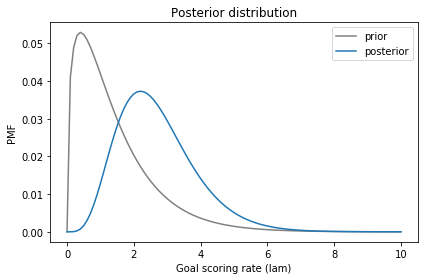

In [41]:
prior.plot(label='prior', color='gray')
posterior.plot(label='posterior', color='C0')

decorate_rate('Posterior distribution')

## The conjugate prior

At the time, I said that I chose the gamma distribution for three reasons:

1. The goal scoring rate is continuous and cannot be less than 0, and the gamma distribution is appropriate for this kind of quantity.

2. The gamma distribution has only one parameter, `alpha`, which is the mean.  So it's easy to construct a gamma distribution with the mean we want.

3. The shape of the Gamma distribution is a reasonable choice, given what we know about soccer.

And I said there was a fourth reason that I would reveal in Chapter 17, so now is the time.

The other reason I chose the gamma distribution is that it is the "conjugate prior" of the Poisson distribution, so-called because the two distributions are connected or coupled, which is what "conjugate" means.

In the next section I'll explain *how* they are connected, but first I'll show you the consequence of this connection, which is that there is a simple closed-form way to compute the posterior distribution.

However, in order to demonstrate it, we have to switch from the one-parameter version of the gamma distribution to the two-parameter version.  Since the first parameter is called `alpha`, you might guess that the second parameter is called `beta`.

The following function takes `alpha` and `beta`, and makes an object that represents a gamma distribution with those parameters.

In [48]:
def make_gamma(alpha, beta):
    """Makes a gamma object.
    
    alpha: shape parameter
    beta: scale parameter
    
    returns: gamma object
    """
    dist = gamma(alpha, scale=1/beta)
    dist.alpha = alpha
    dist.beta = beta
    return dist

Here's the prior distribution with `alpha=1.4` again and `beta=1`. 

In [55]:
alpha = 1.4
beta = 1

prior_gamma = make_gamma(alpha, beta)
prior_gamma.mean()

1.4

Now to do a Bayesian update, I claim, all we have to do is make a gamma distribution with parameters `alpha+k` and `beta+1`.

In [56]:
def update_gamma(prior, data):
    k, t = data
    alpha = prior.alpha + k
    beta = prior.beta + t
    return make_gamma(alpha, beta)

Here's how we update it with the data, which is 4 goals in 1 game.

In [51]:
data = 4, 1
posterior_gamma = update_gamma(prior_gamma, data)

After all the work we did in Chapter 7, it might seem absurd that we can do a Bayesian update by adding two pairs of numbers.
So let's confirm that it works.

I'll evaluate the posterior distribution for each quantity in `lams` and put the results in a `Pmf` object.

In [52]:
ps = posterior_gamma.pdf(lams)
posterior_conjugate = Pmf(ps, lams)
posterior_conjugate.normalize()

9.999714447234826

So `posterior_conjugate` contains a discrete approximation of the posterior distribution we just computed using the conjugate prior.
The following figure shows the result along with the posterior we computed using the grid algorithm.

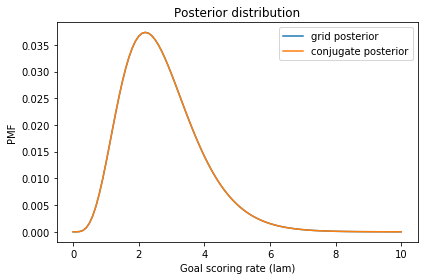

In [57]:
posterior.plot(label='grid posterior', color='C0')
posterior_conjugate.plot(label='conjugate posterior', color='C1')

decorate_rate('Posterior distribution')

They are the same other than small differences due to floating-point approximations.

In [58]:
np.max(np.abs(posterior - posterior_conjugate))

4.163336342344337e-17

## What the actual?

To understand how that works, we'll write the PDF of the gamma prior and the PMF of the Poisson likelihood, then multiply them together, because that's what the Bayesian update does.
We'll see that the result is a gamma distribution, and we'll derive its parameters.

Here's the PDF of the gamma prior, which is the probability density for each value of $\lambda$, given parameters $\alpha$ and $\beta$:

$p(\lambda; \alpha, \beta) = \frac{\beta^\alpha}{\Gamma(\alpha)} \lambda^{\alpha-1}e^{-\beta \lambda}$

The first term does not depend on $\lambda$; it is only needed to normalize the distribution.
Since we are planning to normalize the posterior distribution anyway, we don't really need it.
So I'll write

$p(\lambda; \alpha, \beta) \sim \lambda^{\alpha-1}e^{-\beta \lambda}$

where $\sim$ means "is proportional to".

Now suppose a team scores $k$ goals in $t$ games.  
The probability of this data is given by PMF of the Poisson distribution, which is a function of $k$ with $\lambda t$ as a parameter.

$p(k; \lambda t) = \frac{t^k}{k!} \lambda^k e^{-\lambda t}$

Again, the first term is a normalizing constant that does not depend on $k$, so we can write:

$p(k; \lambda) \sim \lambda^k e^{-\lambda t}$

Omitting the normalizing constants makes it clearer that the gamma and Poisson distributions have the same functional form.
When we multiply them together, we can pair up the factors and add up the exponents.
The result is the unnormalized posterior distribution,

$ \lambda^{\alpha-1+k} e^{-(\beta + t) \lambda}$

which we can recognize as an unnormalized gamma distribution with parameters $\alpha + k$ and $\beta + t$.

This derivation provides insight into what the parameters of the posterior distribution mean: $\alpha$ reflects the number of events that have occurred; $\beta$ reflects the elapsed time.

## Binomial likelihood

As a second example, let's look again at the Euro problem.
When we solved it with a grid algorithm, we started with a uniform prior:

In [88]:
from utils import make_uniform

uniform = make_uniform(0, 1, 101, 'uniform')

In [89]:
from scipy.stats import binom

k, n = 140, 250
xs = uniform.qs

likelihood = binom.pmf(k, n, xs)

In [90]:
posterior = uniform * likelihood
posterior.normalize()

0.0039446175693263405

The binomial distribution, which we use to compute the probability of the data, has a conjugate prior: the beta distribution.

The beta distribution is bounded between 0 and 1, so it works well for representing the distribution of a probability like `x`.

SciPy provides an object called `beta` that represents a beta distribution.
It has two parameters, called `alpha` and `beta`.

The following function takes `alpha` and `beta` and returns a new `beta` object.

In [91]:
import scipy.stats

def make_beta(alpha, beta):
    """Makes a beta object.
    
    alpha: shape parameter
    beta: scale parameter
    
    returns: gamma object
    """
    dist = scipy.stats.beta(alpha, beta)
    dist.alpha = alpha
    dist.beta = beta
    return dist

Now it turns out that the uniform distribution, which we used as a prior, is the beta distribution with parameters `alpha=1` and `beta=1`.

So we can make a `beta` object that represents a uniform distribution, like this:

In [92]:
alpha = 1
beta = 1

prior_beta = make_beta(alpha, beta)
prior_beta.mean()

0.5

Now to do a Bayesian update, I claim, all we have to do is make a gamma distribution with parameters `alpha+k` and `beta+1`.

In [85]:
def update_beta(prior, data):
    k, n = data
    alpha = prior.alpha + k
    beta = prior.beta + n - k
    return make_beta(alpha, beta)

Here's how we update it with the data, which is 4 goals in 1 game.

In [86]:
data = 140, 250
posterior_beta = update_beta(prior_beta, data)
posterior_beta.mean()

0.5595238095238095

After all the work we did in Chapter 7, it might seem absurd that we can do a Bayesian update by adding two pairs of numbers.
So let's confirm that it works.

I'll evaluate the posterior distribution for each quantity in `lams` and put the results in a `Pmf` object.

In [87]:
ps = posterior_beta.pdf(xs)
posterior_conjugate = Pmf(ps, xs)
posterior_conjugate.normalize()

99.99999999999469

So `posterior_conjugate` contains a discrete approximation of the posterior distribution we just computed using the conjugate prior.
The following figure shows the result along with the posterior we computed using the grid algorithm.

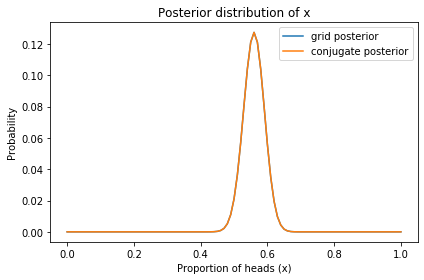

In [78]:
posterior.plot(label='grid posterior')
posterior_conjugate.plot(label='conjugate posterior')

decorate(xlabel='Proportion of heads (x)',
             ylabel='Probability',
             title='Posterior distribution of x')

Here is the PDF of the beta distribution, which is a function of $x$ with $\alpha$ and $\beta$ as parameters.

$ p_{beta}(x; \alpha, \beta) = \frac{\Gamma(\alpha+\beta)}{\Gamma(\alpha)\Gamma(\beta)} x^{\alpha-1} (1-x)^{\beta-1}$ 

$\Gamma$ represents the gamma function, but we don't need to concern ourselves; the first factor is a normalizing constant that does not depend on `x`, so we can leave it out:

$ p_{beta}(x; \alpha, \beta) \sim x^{\alpha-1} (1-x)^{\beta-1}$

And that might look familiar, if you remember the PMF of the binomial distribution, which has the same form, but which we interpret as a function of $k$ with $n$ and $x$ as parameters.

$ p_{binom}(k; n, x) = \binom{n}{k} x^{k} (1-x)^{n-k} $

Again, the first factor does not depend on $x$, so we can write:

$ p_{binom}(k; n, x) \sim x^{k} (1-x)^{n-k} $

And now when we multiply the beta prior and the binomial likelihood, the result is

$x^{\alpha-1+k} (1-x)^{\beta-1+n-k} \sim p_{beta}(x; \alpha+k, \beta+n-k)$

Which we recognize as an unnormalized beta distribution with parameters $\alpha+k$ and $\beta+n-k$.

Again, the conjugate prior gives us insight into the meaning of the parameters; $\alpha$ is related to the number of observed successes; $\beta$ is related to the number of failures.

## Summary



## Exercises

**Exercise:** In the second version of the World Cup problem, the data we use for the update is not the number of goals in a game, but the time until the first goal (in units of games).

So the probability of the data is given by the exponential distribution rather than the Poisson distribution.  
But it turns out that the gamma distribution is *also* the conjugate prior of the exponential distribution, so there is a simple closed-form way to compute this update, too.

The PDF of the exponential distribution is a function of $t$ with $\lambda$ as a parameter.

$p(t; \lambda) = \lambda e^{-\lambda t}$

Multiply the PDF of the gamma prior by this likelihood, confirm that the result is an unnormalized gamma distribution, and see if you can derive its parameters.

Write a few lines of code to update `prior_gamma` with the data from this version of the problem, which was a goal after 11 minutes, or 11/90 of a game.

In [60]:
# Solution

"""
The unnormalized posterior is

\lambda^{\alpha-1+1} e^{-(\beta + t) \lambda}

which is an unnormalized gamma distribution with parameters
`alpha+1` and `beta+t`, which means that we observed 1 goal
in elapsed time `t`.

So we can use the same update function, and call it like this:
"""

data = 1, t
update_gamma(prior_gamma, data)

**Exercise:**  The positive review question from 3Blue1Brown